# Point-scanning micro-endoscopy through a multimode fiber

See section 2.5 in the paper for the full experiment.

The data we use in this notebook comes from [Turcotte et al.](https://opg.optica.org/boe/fulltext.cfm?uri=boe-11-8-4759&id=433935) Refer to them for further details about the data as well as some of the basic image processing.

See the demo.ipynb for a more basic tutorial

## Setup

Here we import some necessary packages/helper functions

In [1]:
import sys
sys.path.append("..") # since the package is one level above. Normally you should keep them on the same!

import rdmpy

# here are some basics we will need for the demo
import torch
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from skimage.transform import resize
from scipy.ndimage import gaussian_filter
from PIL import Image

# Fill this in according to your computer, we highly recommend using a GPU.
# We needed ~20GB of GPU memory to run at full resolution (1024 x 1024).
if torch.cuda.is_available():
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')
    
    
print('Using ' +str(device) + ' for computation')

def center_crop(img, des_shape, m_center=None):
    if m_center is None:
        m_center = (img.shape[0] // 2, img.shape[1] // 2)
    left, right, up, down = (
        m_center[1] - des_shape[1] // 2,
        m_center[1] + int(np.round(des_shape[1] / 2)),
        m_center[0] - des_shape[0] // 2,
        m_center[0] + int(np.round(des_shape[0] / 2)),
    )
    img = img[up:down, left:right]
    return img

def crop(img, c):
    return img[c:-c,c:-c]

BLUE = 488e-9

/home/amit/miniconda3/envs/rdm_test/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/home/amit/miniconda3/envs/rdm_test/lib/python3.8/site-packages/skimage/util/dtype.py:27: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),


Using cuda:1 for computation


## One-time Calibration

Here the calibration image is 5 randomly scattered 0.1 micron beads. 

In [2]:
dim = 120
upsample = 3 # upsampling factor chosen by the Turcotte et al. for smoothing.
dim = dim*upsample

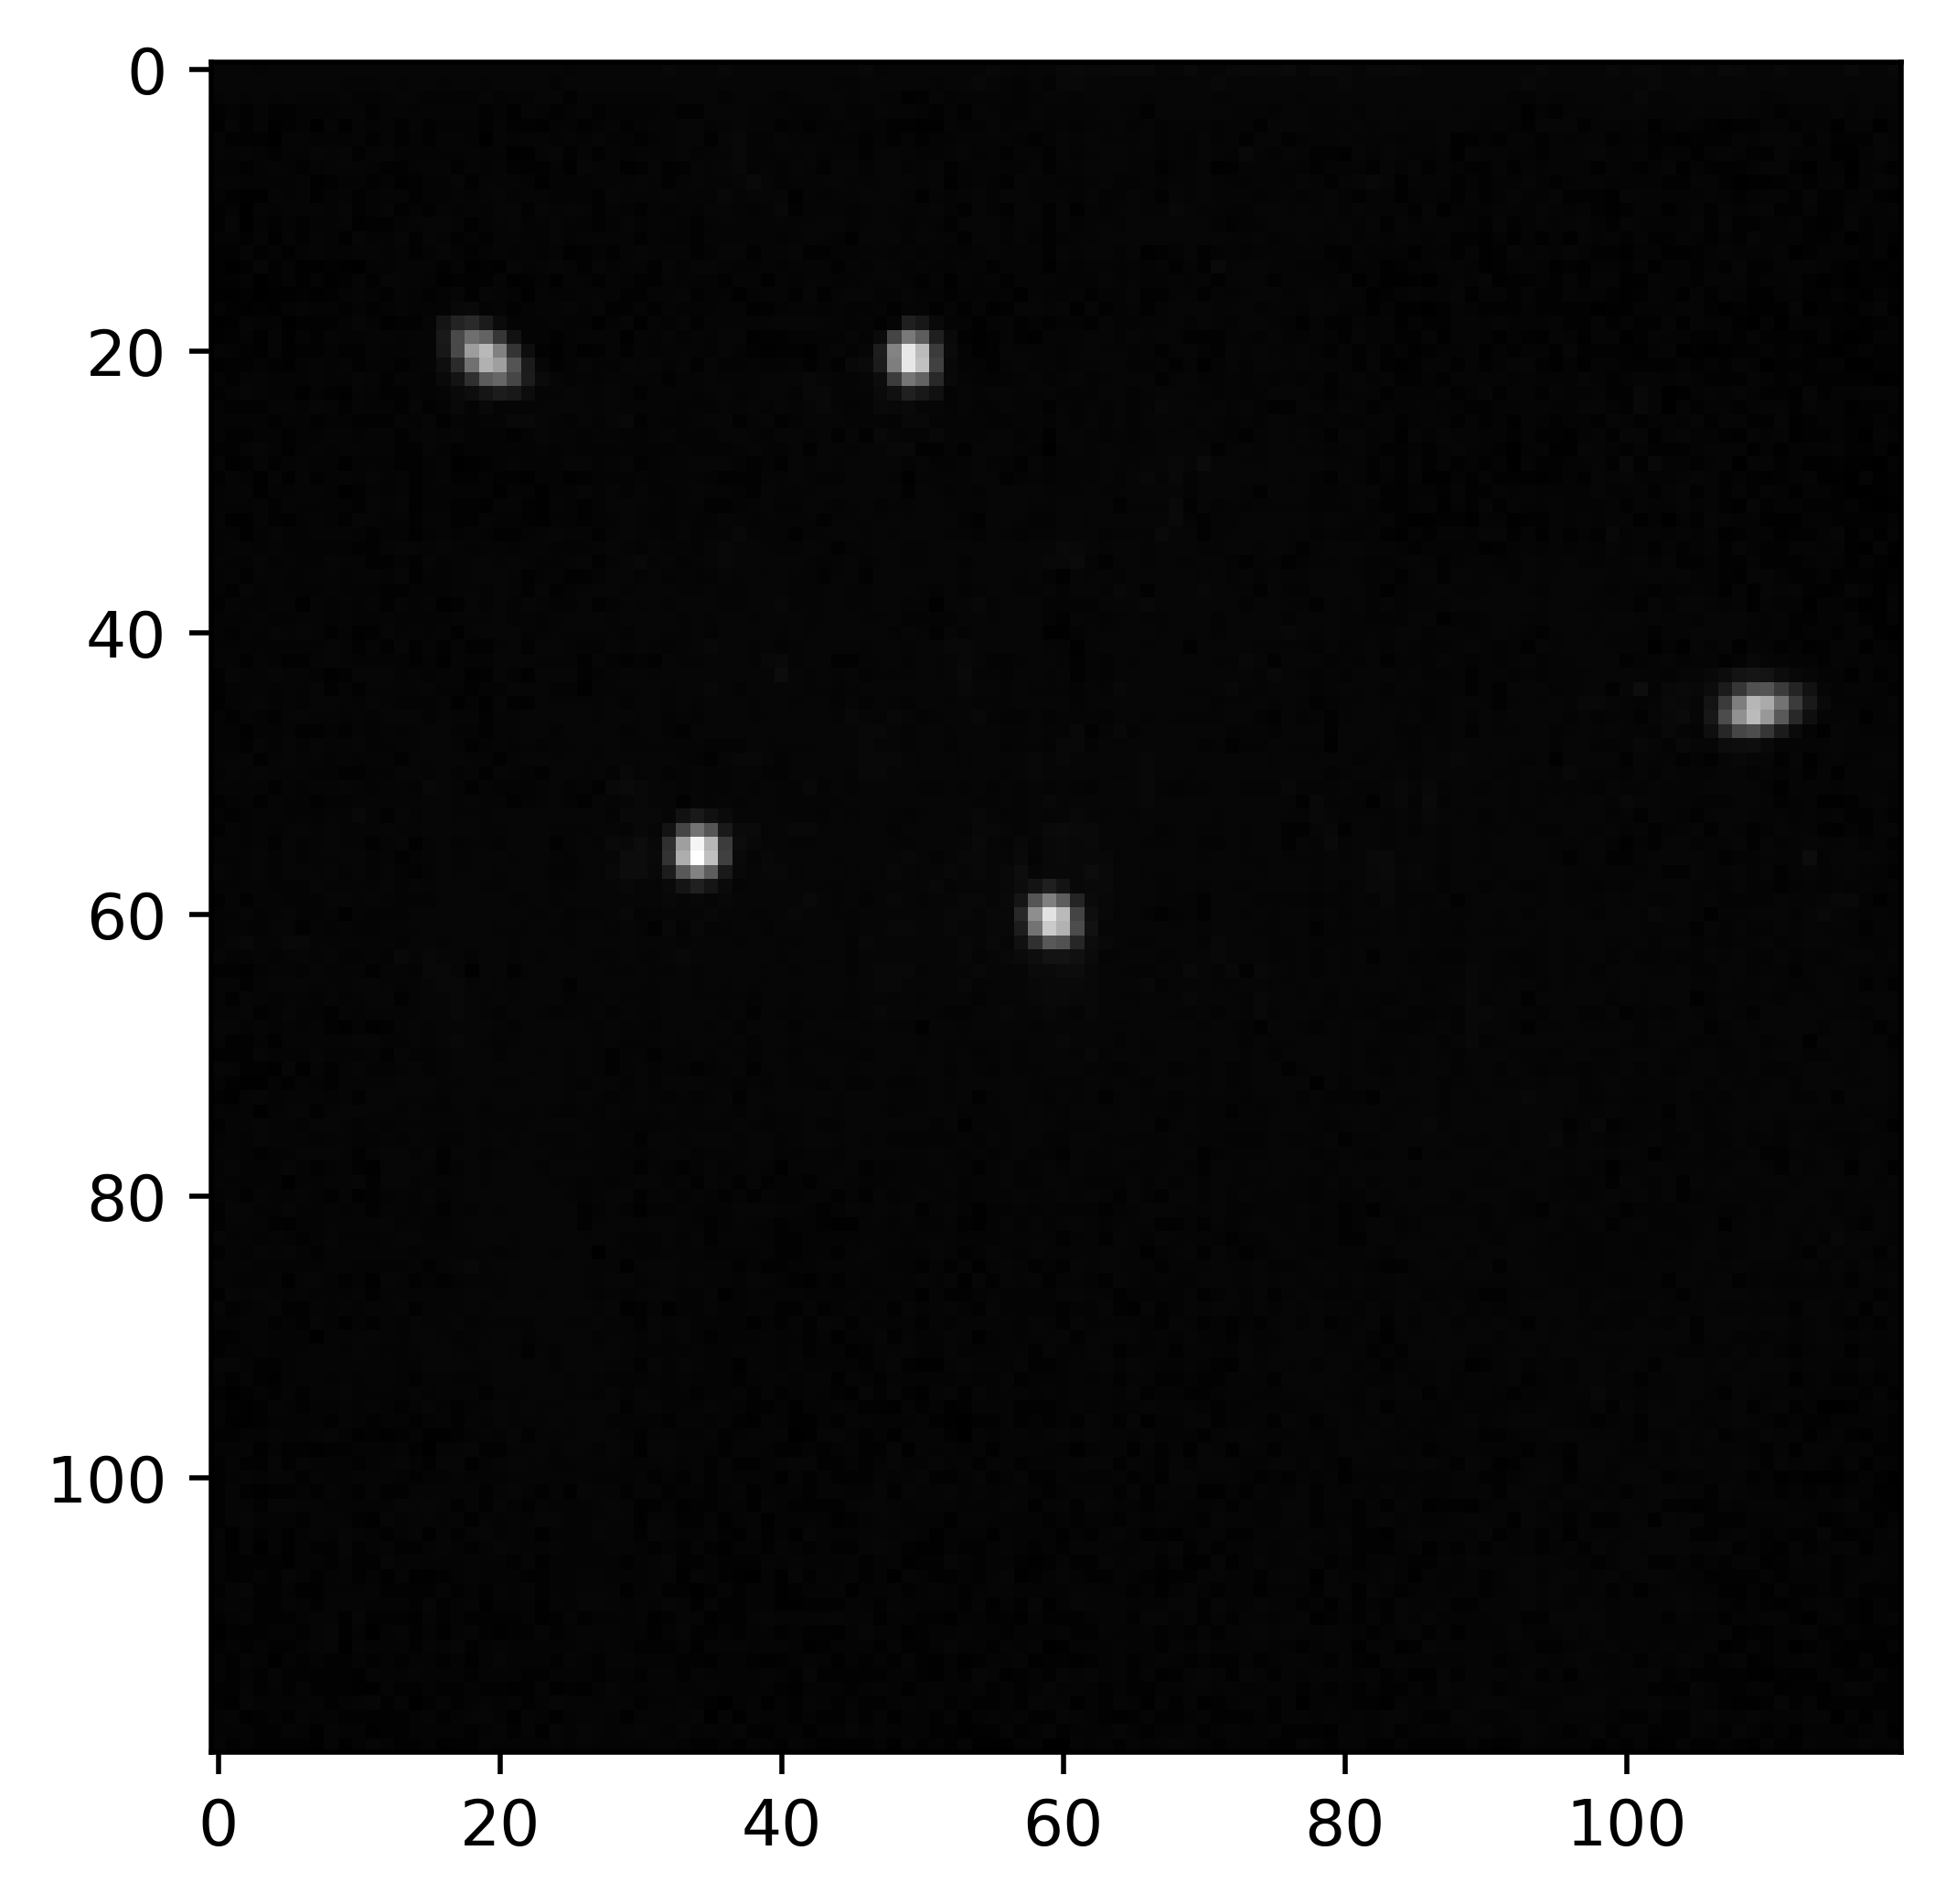

In [3]:
calibration_image = plt.imread('rdm_data/mmf/calibration/calib_img.tif').copy()
plt.imshow(center_crop(calibration_image, [dim,dim]), cmap='gray')
plt.show()

fitting seidel coefficients...


100%|█████████████████████████████████████████| 500/500 [00:10<00:00, 48.31it/s]


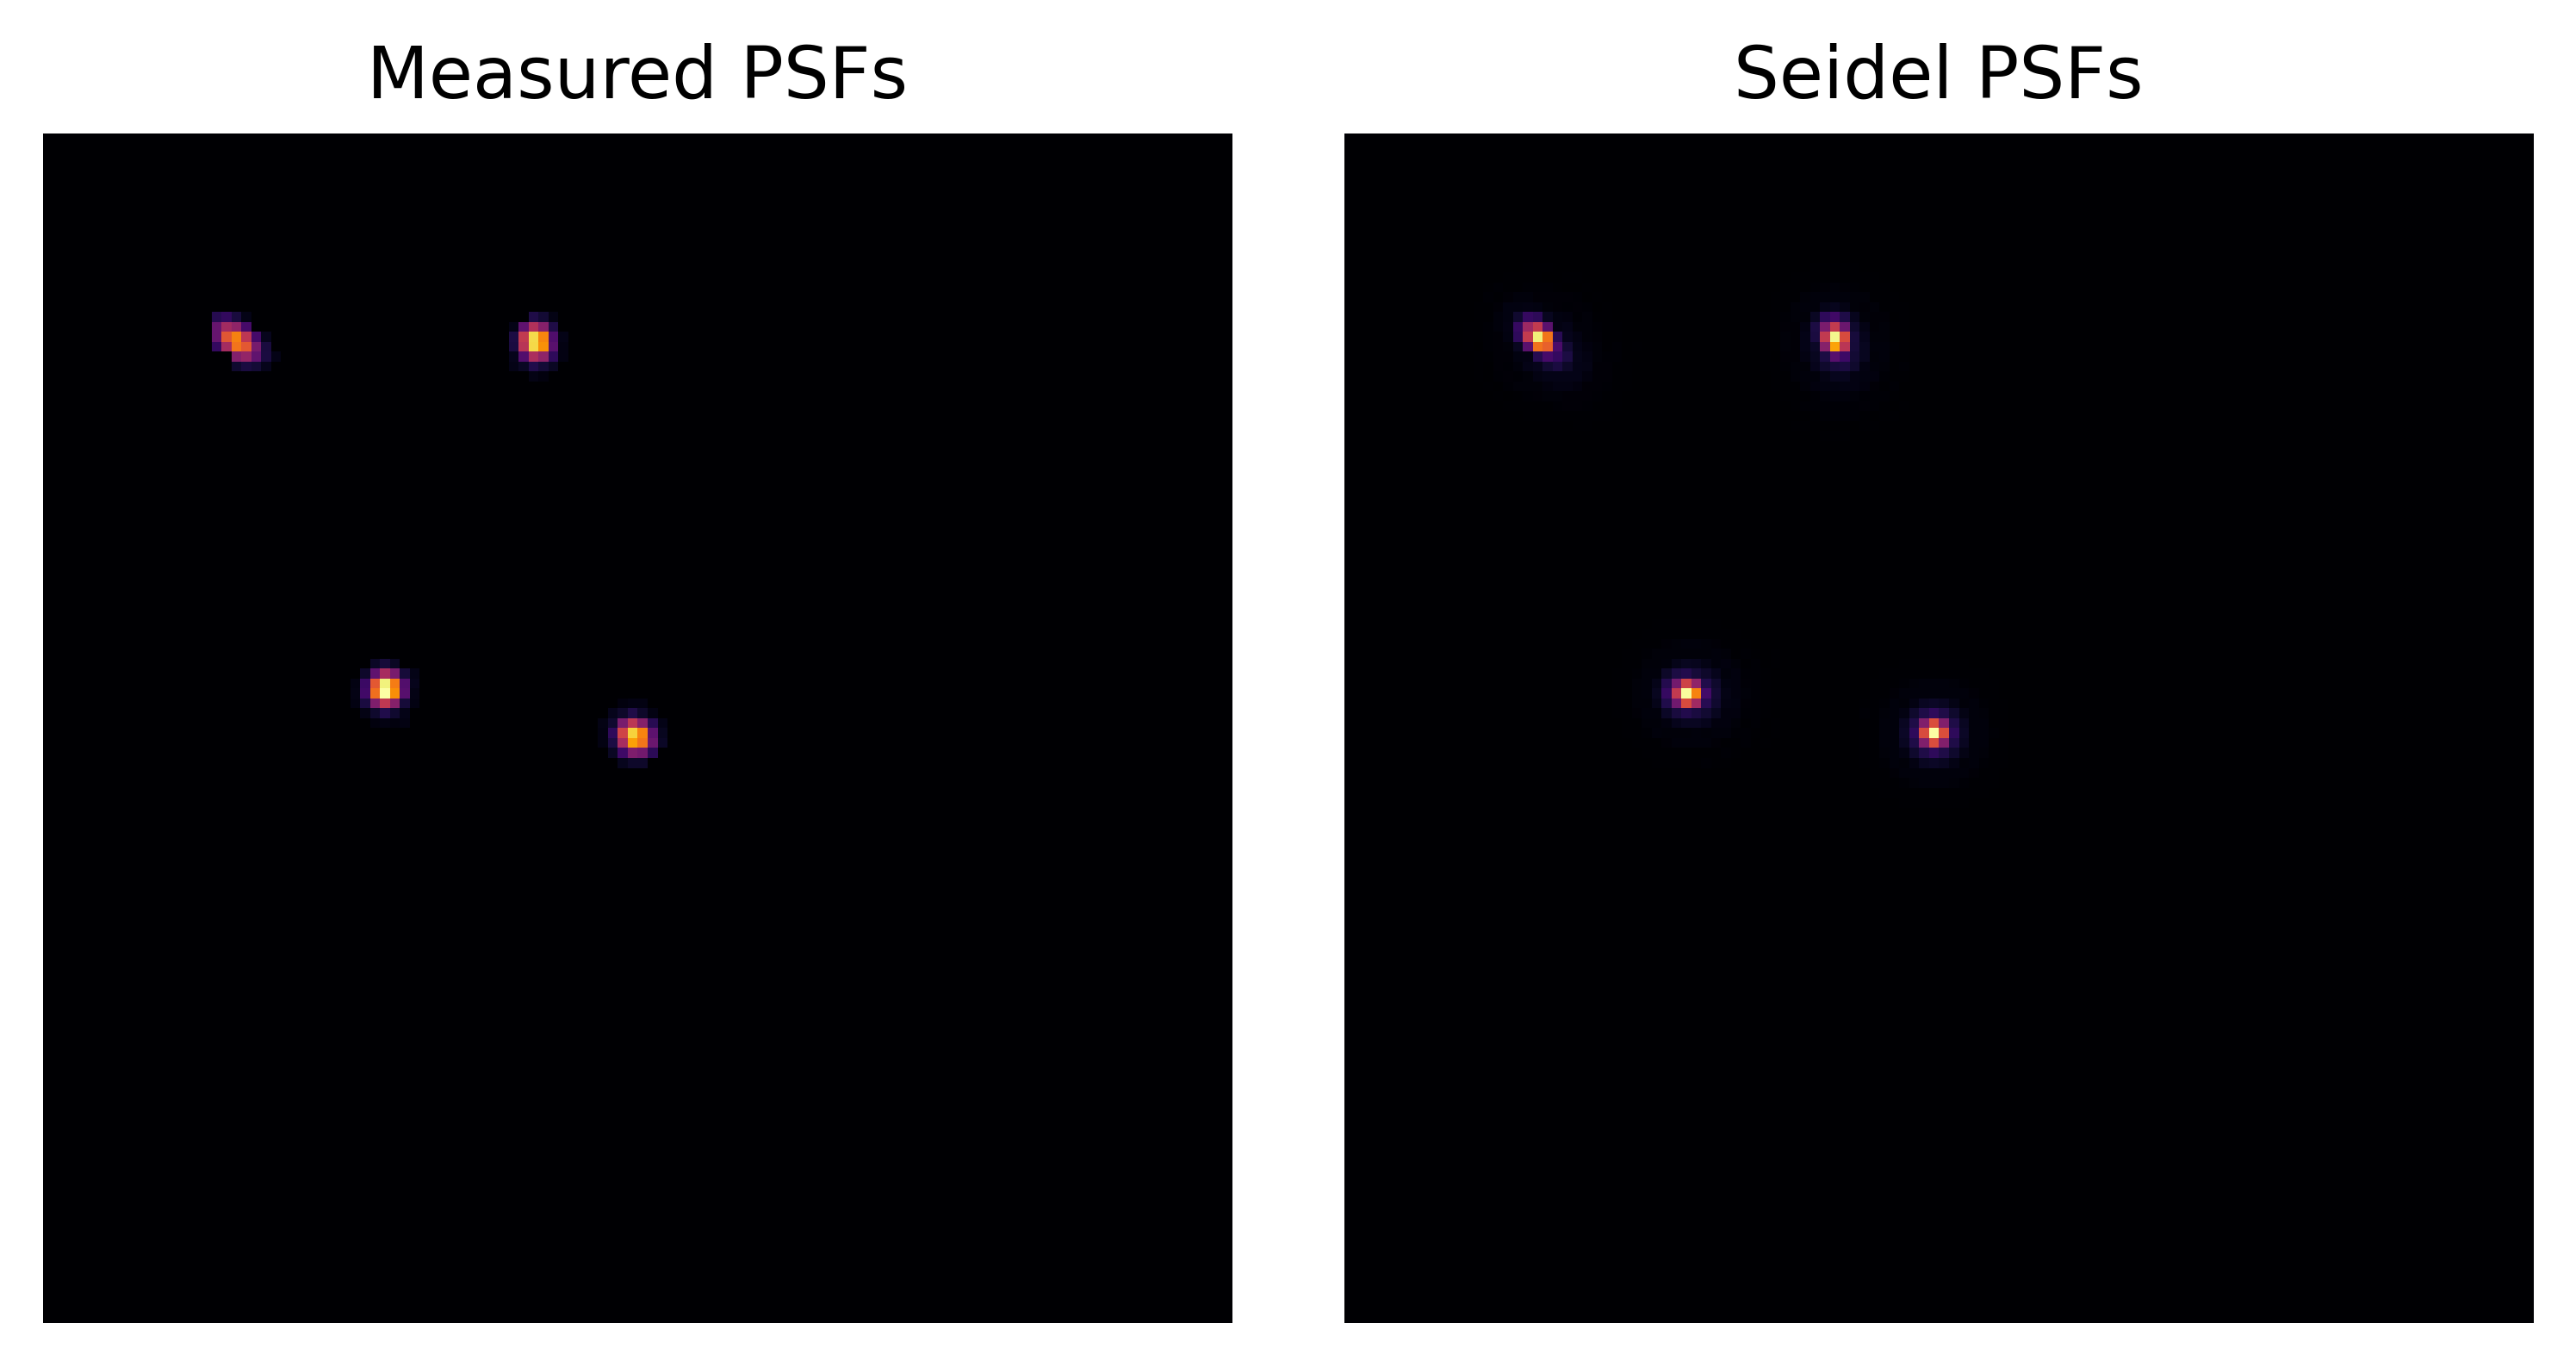

Fitted seidel coefficients: tensor([[0.4356],
        [0.2190],
        [0.2560],
        [0.1513],
        [0.0000],
        [0.0000]])


In [4]:
fit_params={
        "iters": 500,
        "threshold": 0.1,
        "disk": 1,
        "lr": 1e-3,
        "min_distance": 10,
    }

seidel_coeffs = rdmpy.calibrate(calibration_image, dim=dim//upsample, device=device, show_psfs=True, get_psf_data=False, sys_params={"lamb": BLUE}, fit_params=fit_params)

## 1 micron beads
Now that we have our fitted Seidel coefficients, we can deblur some 1 micron beads with ring deconvolution. First we render out upsampled PSFs using the rdmpy upsampling feature. Then we deblur 2 instances of 1 micron bead distributions. 


In [5]:
# render the PSFs (normally would do this in the previous step, but we want to upsample them for the beads)
upsampled_psfs = rdmpy.get_psfs(
    seidel_coeffs,
    dim // upsample,
    model="lri",
    sys_params={"lamb": BLUE},
    downsample=1 / upsample,
    device=device,
)

rendering PSFs...


  0%|                                                   | 0/360 [00:00<?, ?it/s]/home/amit/miniconda3/envs/rdm_test/lib/python3.8/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
100%|█████████████████████████████████████████| 360/360 [00:08<00:00, 43.71it/s]


100%|█████████████████████████████████████████| 300/300 [00:32<00:00,  9.11it/s]


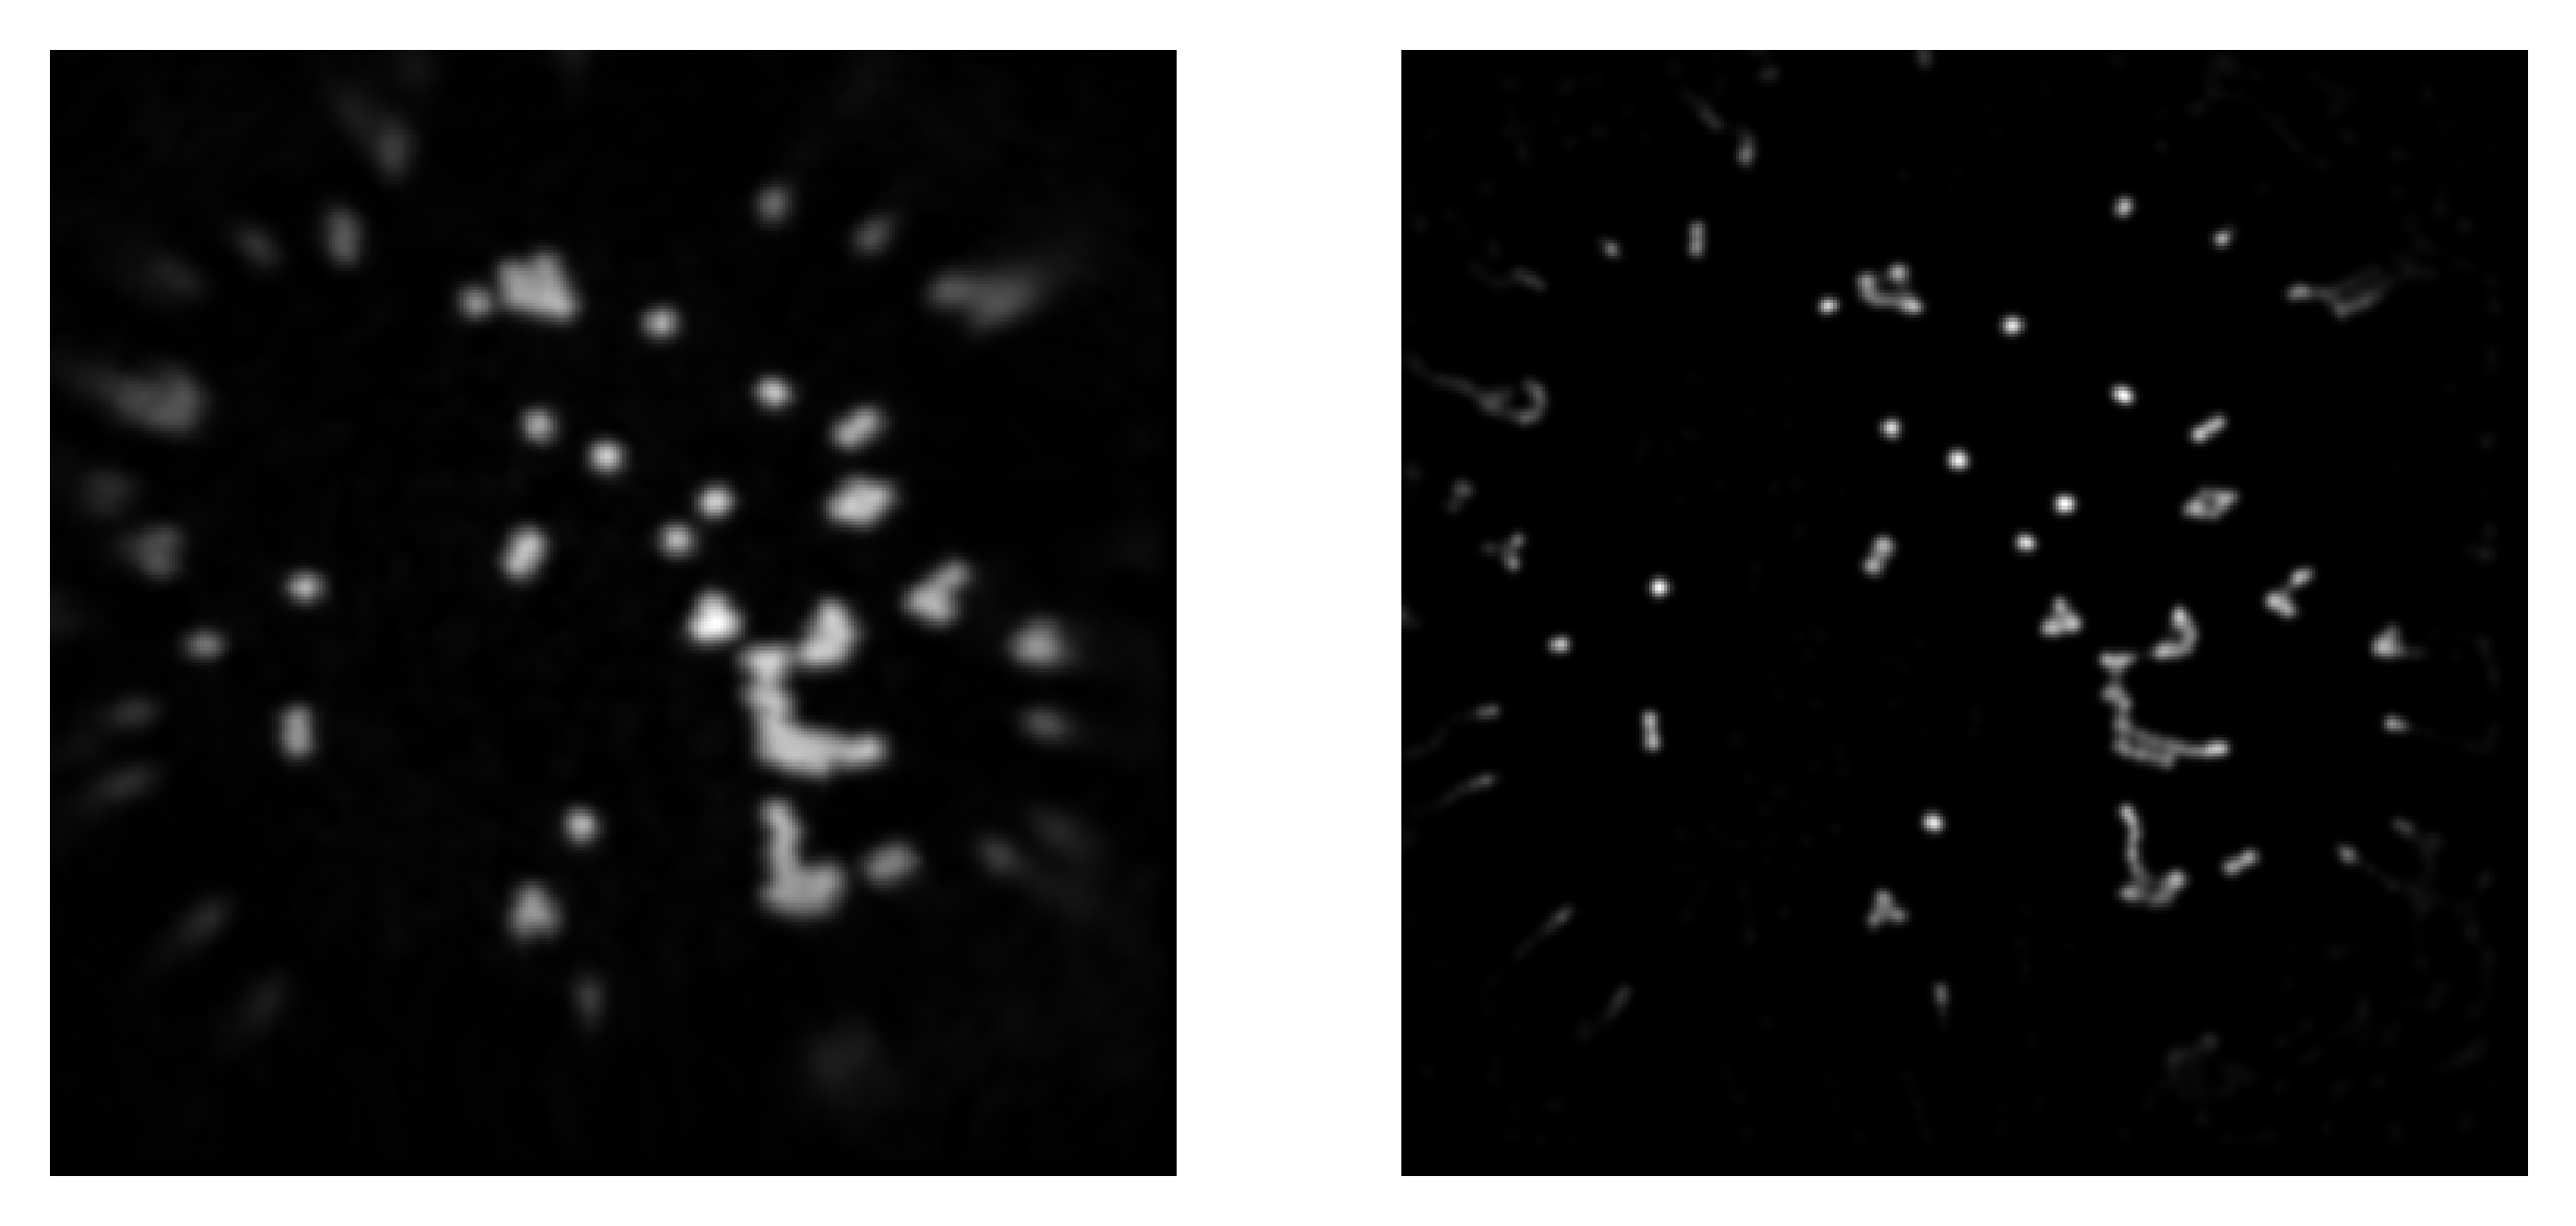

In [6]:
beads1 = plt.imread('rdm_data/mmf/beads/Set3-3x.tif') / 255.0
beads1 = np.concatenate([beads1, np.zeros([3, dim - 3])], axis=0) # these 2 lines correct dimension mismatch
beads1 = np.concatenate([beads1, np.zeros([dim, 3])], axis=1)
#now deblur with ring deconvolution
beads1_recon = rdmpy.ring_deconvolve(
    beads1,
    upsampled_psfs,
    process=False,
    opt_params={
        "lr": 5e-2,
        "iters": 300,
        "tv_reg": 1e-10,
        "l2_reg": 1e-8,
        "l1_reg": 0,
    },
    device=device,
)

beads1_recon = gaussian_filter(beads1_recon, sigma=(3.0 / 2.0)) # Gaussian blur as per Turcotte et al.
beads1_recon = beads1_recon/beads1_recon.max()

# plot raw and ring deconvolved beads
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(beads1, cmap='gray')
ax1.axis('off')
ax2.imshow(beads1_recon, cmap='gray')
ax2.axis('off') 
plt.show()

100%|█████████████████████████████████████████| 300/300 [00:33<00:00,  9.05it/s]


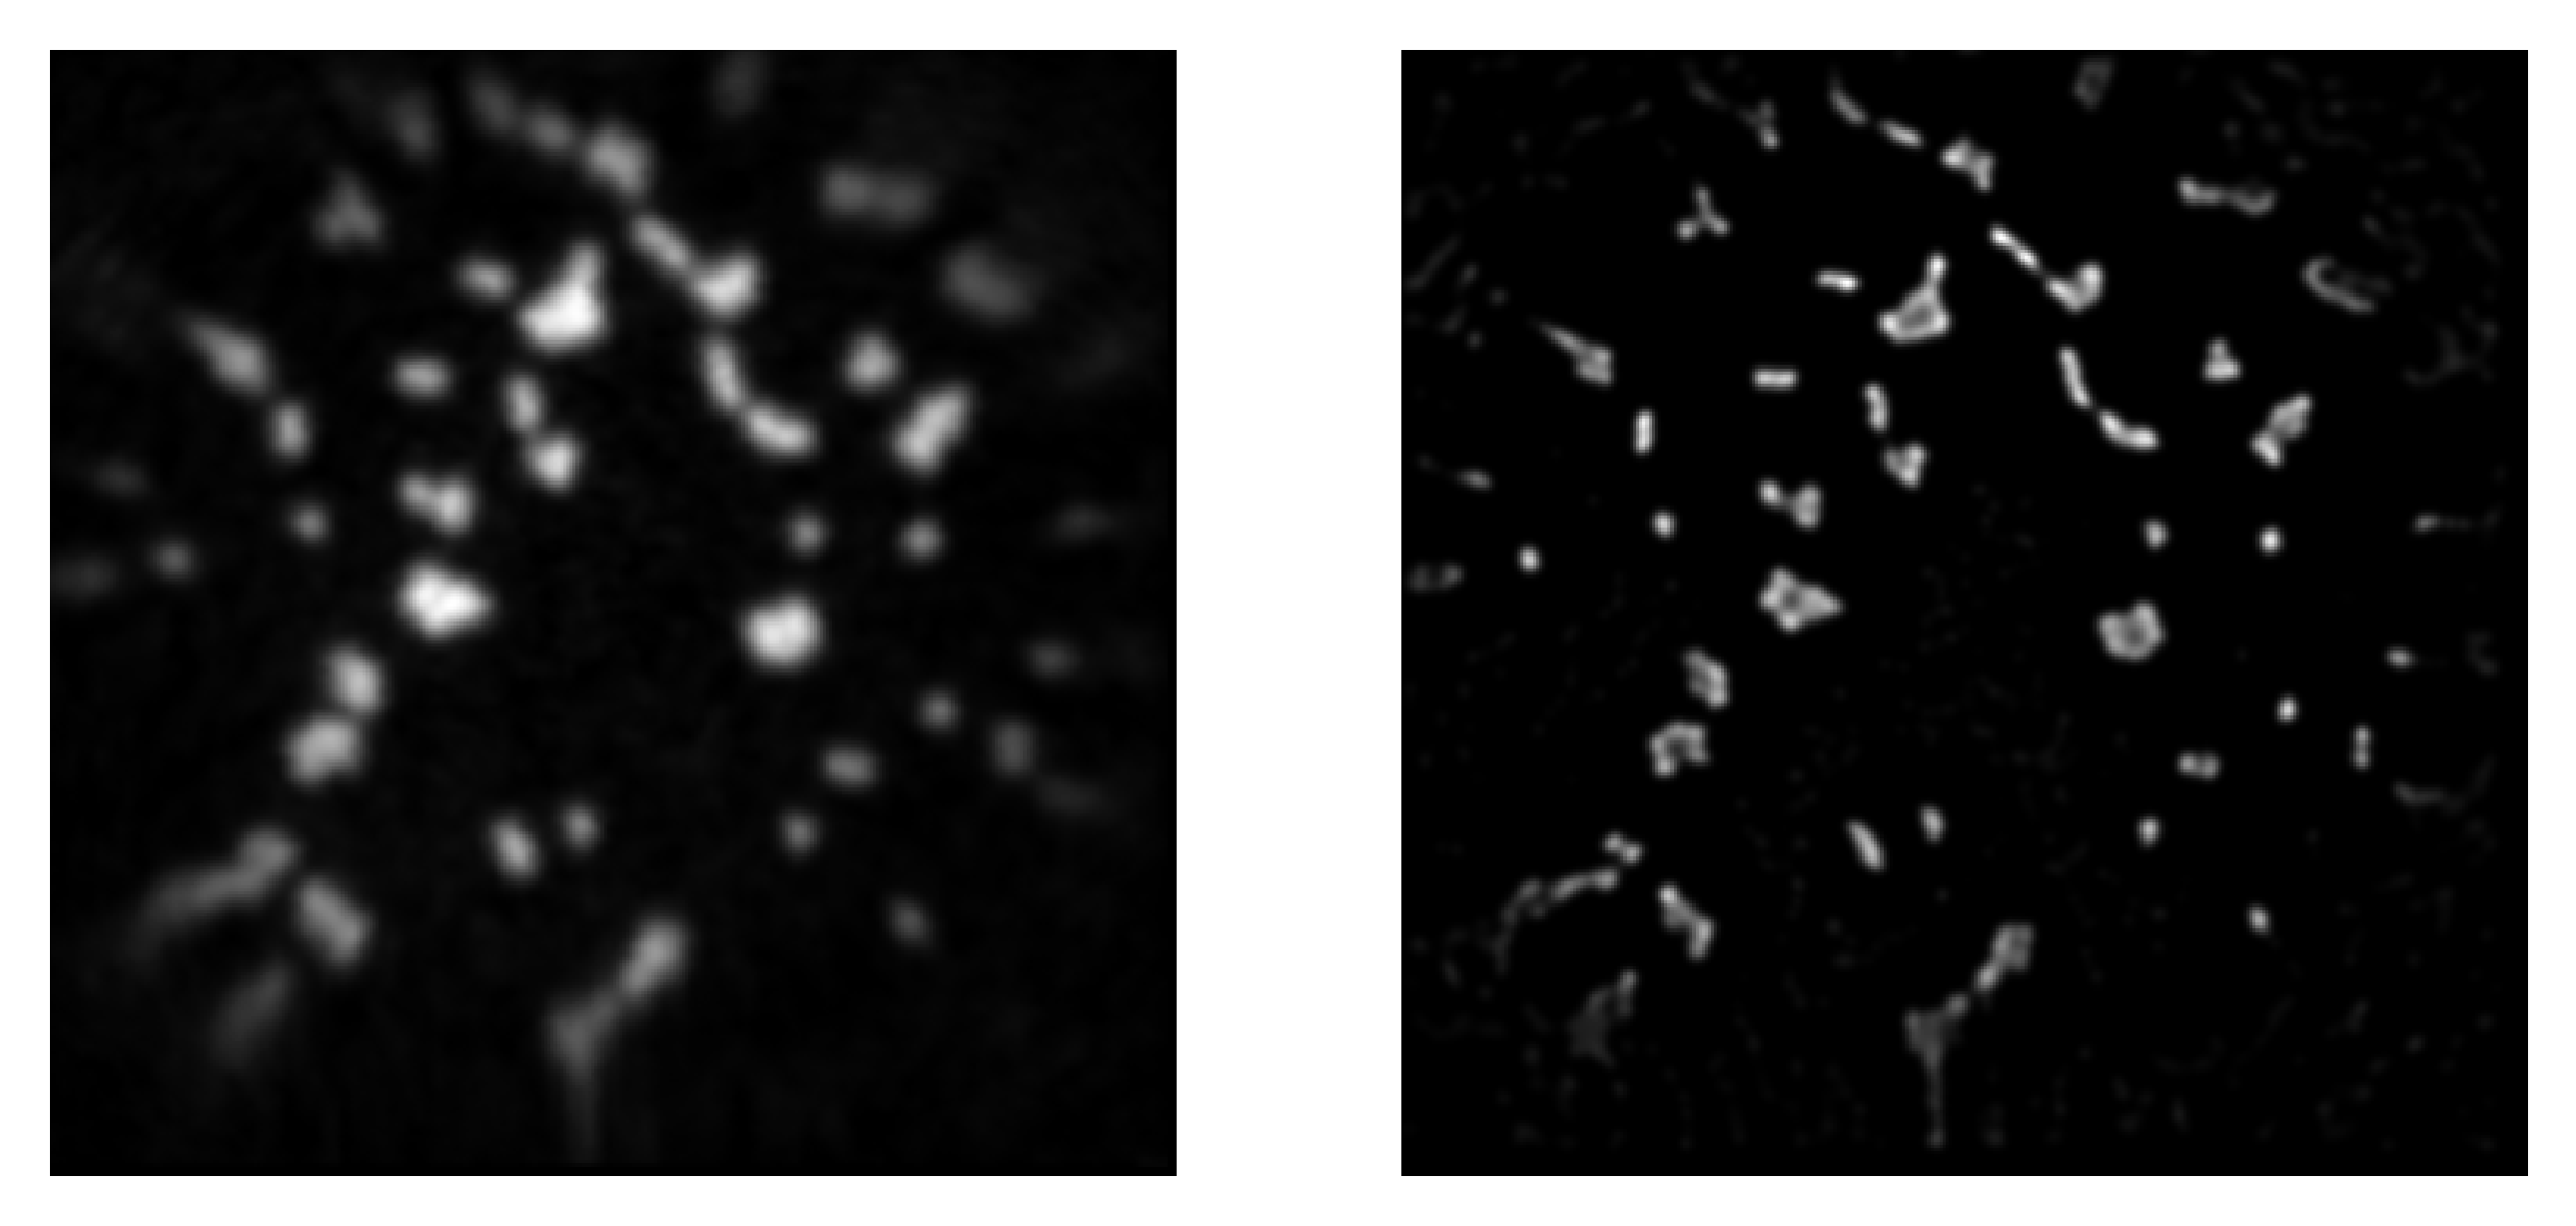

In [7]:
beads2 = plt.imread('rdm_data/mmf/beads/Set2-3x.tif') / 255.0
beads2 = np.concatenate([beads2, np.zeros([3, dim - 3])], axis=0) # these 2 lines correct dimension mismatch
beads2 = np.concatenate([beads2, np.zeros([dim, 3])], axis=1)
#now deblur with ring deconvolution
beads2_recon = rdmpy.ring_deconvolve(
    beads2,
    upsampled_psfs,
    process=False,
    opt_params={
        "lr": 5e-2,
        "iters": 300,
        "tv_reg": 1e-10,
        "l2_reg": 1e-8,
        "l1_reg": 0,
    },
    device=device,
)

beads2_recon = gaussian_filter(beads2_recon, sigma=(3.0 / 2.0)) # Gaussian blur as per Turcotte et al.
beads2_recon = beads2_recon/beads2_recon.max()

# plot raw and ring deconvolved beads
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(beads2, cmap='gray')
ax1.axis('off')
ax2.imshow(beads2_recon, cmap='gray')
ax2.axis('off') 
plt.show()

## Live rat neurons
We can apply the same strategy to live rat neurons. We won't upsample this time in accordance with Turcotte et al.

In [8]:
# get the non-upsampled PSFs from the seidel coefficients
seidel_psfs = rdmpy.get_psfs(
    seidel_coeffs,
    dim // upsample,
    model="lri",
    sys_params={"lamb": BLUE},
    device=device,
)

rendering PSFs...


100%|████████████████████████████████████████| 120/120 [00:00<00:00, 267.85it/s]


100%|█████████████████████████████████████████| 300/300 [00:09<00:00, 30.83it/s]


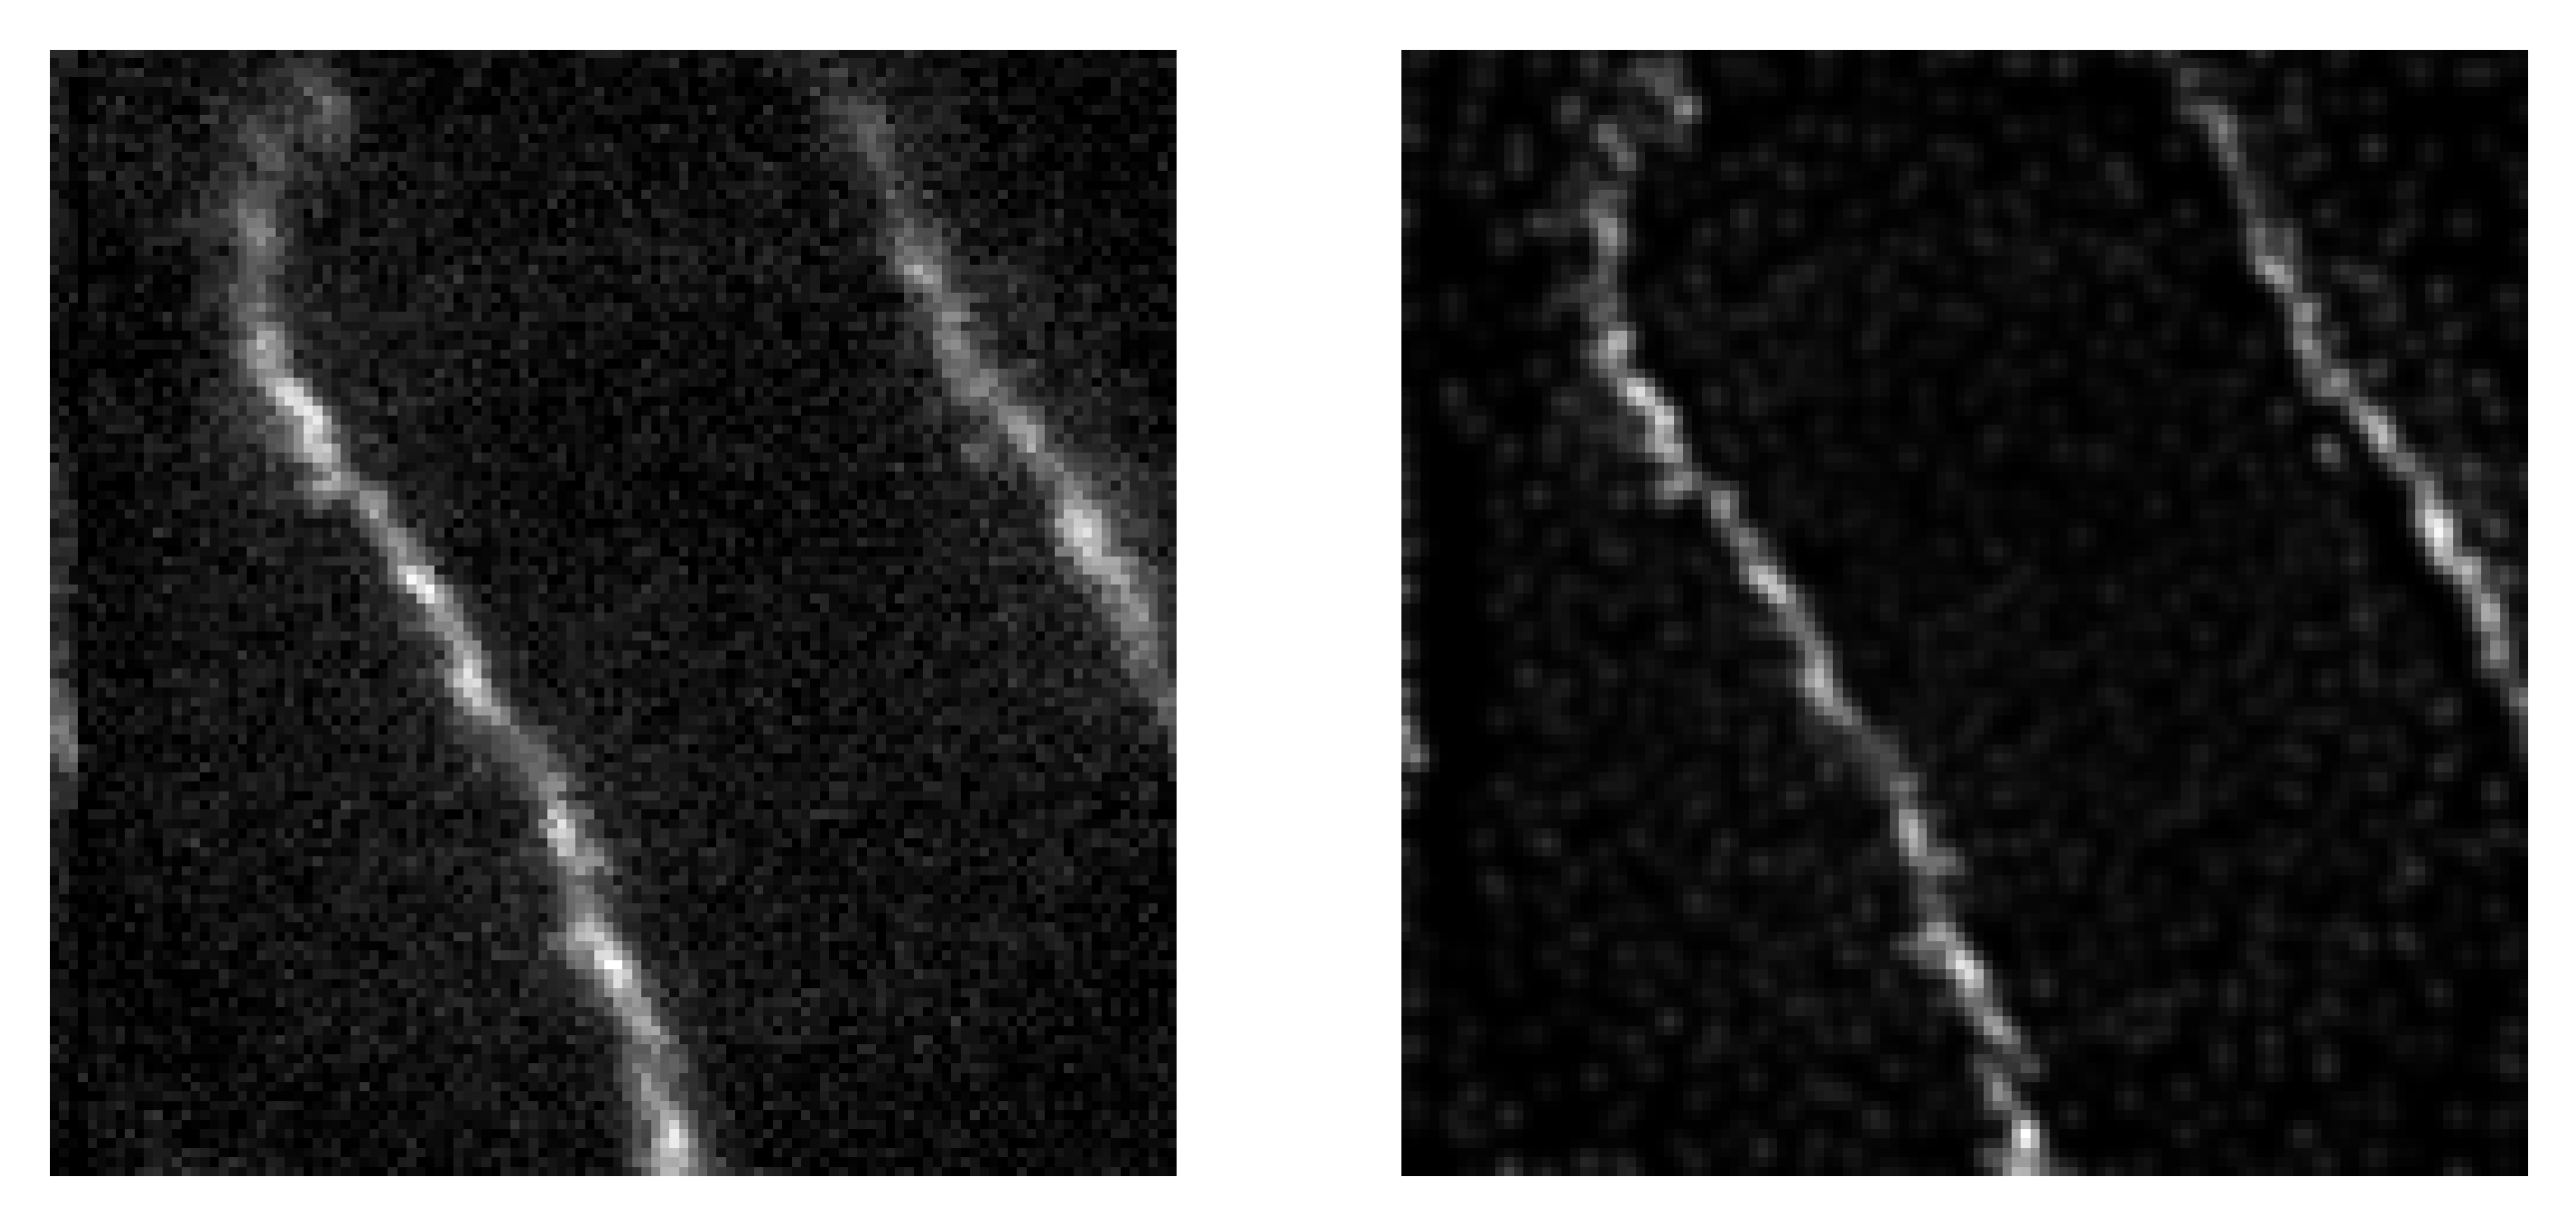

In [9]:
neurons1 = plt.imread('rdm_data/mmf/neurons/163424f.tif') / 255.0
#now deblur with ring deconvolution
neurons1_recon = rdmpy.ring_deconvolve(
    neurons1,
    seidel_psfs,
    process=False,
    opt_params={
        "lr": 5e-2,
        "iters": 300,
        "tv_reg": 1e-10,
        "l2_reg": 1e-8,
        "l1_reg": 0,
    },
    device=device,
)

neurons1_recon = gaussian_filter(neurons1_recon, sigma=(3.0 / 3.0)) # Gaussian blur as per Turcotte et al.
neurons1_recon = neurons1_recon/neurons1_recon.max()

# plot raw and ring deconvolved neurons
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(neurons1, cmap='gray')
ax1.axis('off')
ax2.imshow(neurons1_recon, cmap='gray')
ax2.axis('off') 
plt.show()

100%|█████████████████████████████████████████| 300/300 [00:09<00:00, 30.81it/s]


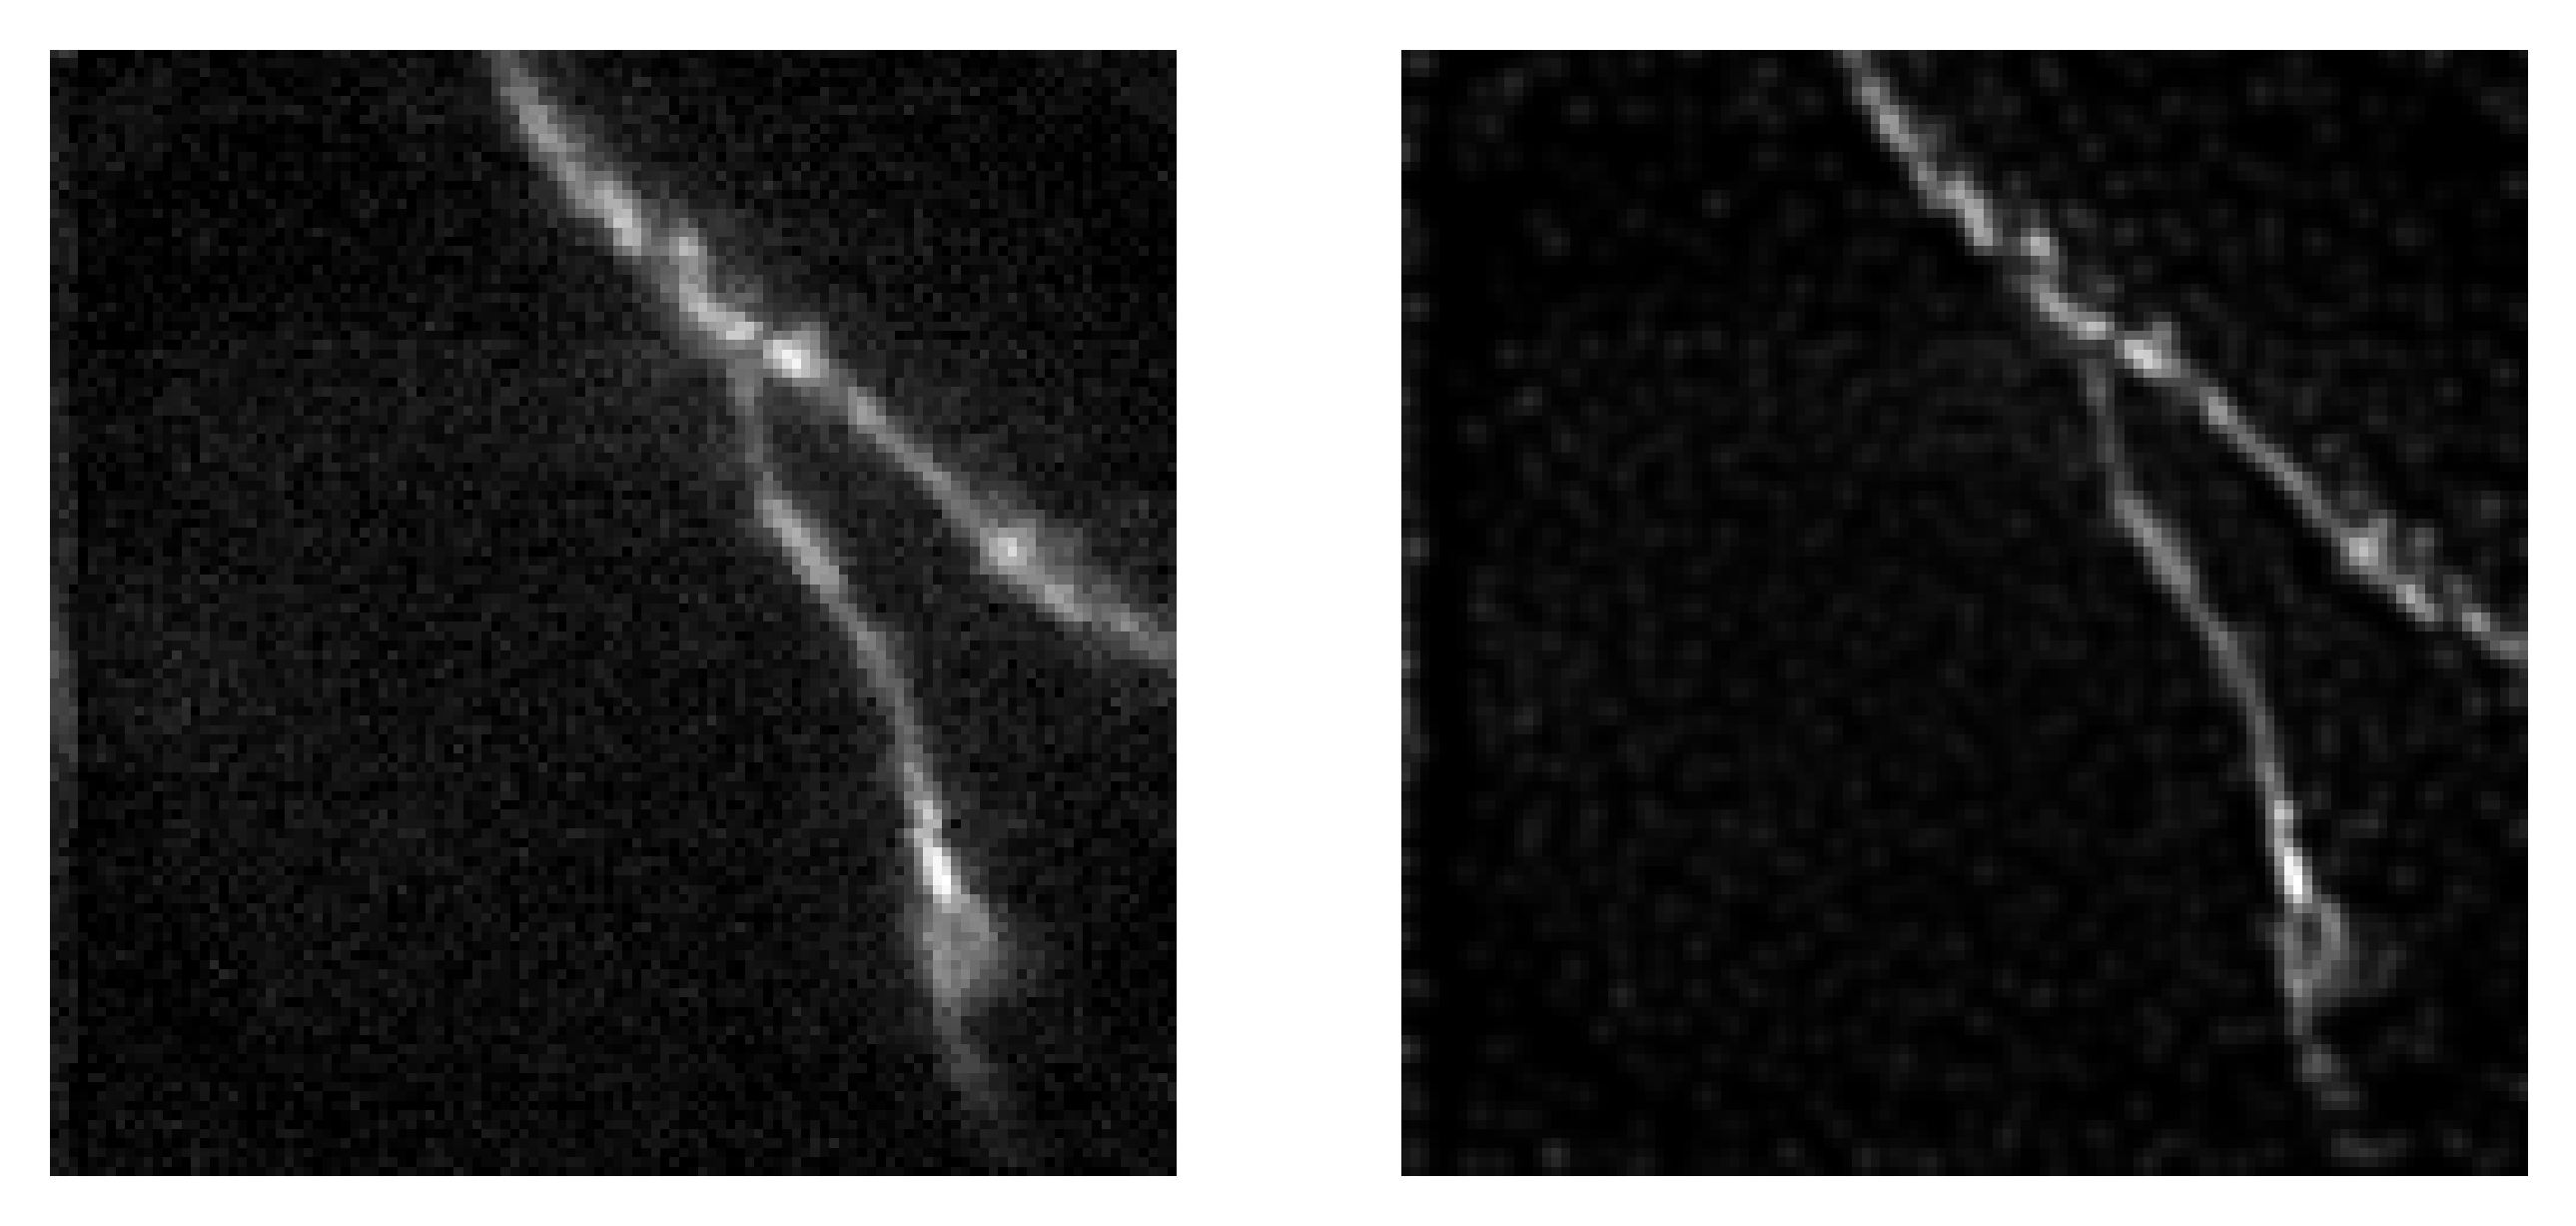

In [10]:
neurons2 = plt.imread('rdm_data/mmf/neurons/154624f.tif') / 255.0
#now deblur with ring deconvolution
neurons2_recon = rdmpy.ring_deconvolve(
    neurons2,
    seidel_psfs,
    process=False,
    opt_params={
        "lr": 5e-2,
        "iters": 300,
        "tv_reg": 1e-10,
        "l2_reg": 1e-8,
        "l1_reg": 0,
    },
    device=device,
)

neurons2_recon = gaussian_filter(neurons2_recon, sigma=(3.0 / 3.0)) # Gaussian blur as per Turcotte et al.
neurons2_recon = neurons2_recon/neurons2_recon.max()

# plot raw and ring deconvolved neurons
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(neurons2, cmap='gray')
ax1.axis('off')
ax2.imshow(neurons2_recon, cmap='gray')
ax2.axis('off') 
plt.show()